The aim of the present notebook is to illustrate the use of the MAYO pipeline. We reproduce the disk + 2 synthetic planets experiment corresponding to Sec. 5.4 from the MAYO paper. 

In [1]:
from hciplot import plot_frames as plots
import matplotlib.pyplot as plt
import numpy as np
import vip_hci as vip
import sys
import json
sys.path.append('../../')   # append the path to mayo_hci
import mayo_hci

The pipeline is mostly automated and most of the MAYO pipeline is done under the hood during the instantiation of the class (steps 3 to 6 from Algorithm 2) are performed). In addition, the current version also loads the data and injects the synthetic data if needed. All the parameters of MAYO are written in a json file called parameters_algo.json and placed in a working_directory.

In [2]:
working_directory = './'
with open(working_directory+'parameters_algo.json', 'r') as read_file_parameters_algo:
    parameters_algo = json.load(read_file_parameters_algo)

print(parameters_algo)

{'data_name': 'example-data', 'channel': 0, 'crop': 0, 'min_objective': 'huber_loss', 'rank': 6, 'regularization_disk': 23750.0, 'regularization_planet': 40, 'conv': True, 'sparseBasis': 'shearlets', 'scales': 4, 'mask_center': 8, 'regularization': 'constraint', 'tol': 0.0001, 'max_iter': 10000, 'greedy_n_iter': 10, 'greedy_n_iter_in_rank': 10, 'greedy_mask': 8, 'stop-optim': False}


data_name, channel, and crop are used to load the dataset.

min_objective : allows to choose between huber_loss, l2 and l1 norms for the fidelity term.

rank , regularization_disk, and regularization_planet correspond to $r$, $\tau_d$, and $\tau_p$ respectively.

conv, if the off-axis psf is unavailable, we can run MAYO without deconvolution.

sparseBasis and scales are used to specify the disk regularization.

regularization allows to change the type of regularization (constraint or lasso), but this is not used in MAYO anymore.

mask_center is $\omega$, the radius of $\mathcal M$.

tol and max_iter are used for the stopping criterion of the optimization.

greedy_n_iter greedy_n_iter_in_rank correspond to $\rho$ and $l$, for GreeDS.

greedy_mask is the mask used in GreeDS, should be set to the same value as mask_center.

Finally, stop-optim is set to true when the the stopping criterion is reached

The parameters of the injected synthetic signal is found in the add_synthetic_signal.json file: 

In [3]:
with open(working_directory+'add_synthetic_signal.json', 'r') as read_file_add_synthetic_signal:
    add_synthetic_signal = json.load(read_file_add_synthetic_signal)

print(add_synthetic_signal)


{'disk_max_intensity': 1.5, 'disk_inclination': 60, 'planets_positions_intensities': [[162, 72, 10], [117, 182, 20]]}


The MAYO pipeline is instantiated, the data is loaded, synthetic signal injected, and steps 3 to 6 from Algorithm 2 are performed:

In [4]:
algo = mayo_hci.all_ADI_sequence_mayonnaise_pipeline(working_directory) 

Fits HDU-0 data successfully loaded. Data shape: (48, 256, 256)
imported cube on channel: h2
Fits HDU-0 data successfully loaded. Data shape: (48,)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
(64, 64)
(64, 64)
dimension of psf modified to fit data
psf normalized


/Users/bpairet/miniconda/envs/vip_new/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


Synthetic signal added to data
Fits HDU-0 data successfully loaded. Data shape: (10, 256, 256)
Fits HDU-0 data successfully loaded. Data shape: (48, 256, 256)


KeyboardInterrupt: 

We can, for instance, check that the HuberFit worked as planned:

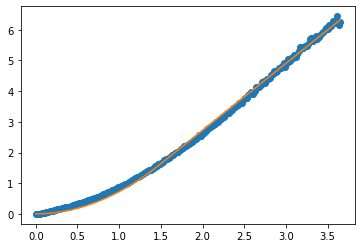

In [5]:
plt.plot(algo.negative_log_hist_x,algo.negative_log_hist_y,'o')
delta = algo.fitted_pw[0]
c = algo.fitted_pw[1]
fitted_huber = mayo_hci.operators.compute_huber_loss(algo.negative_log_hist_x,delta,c)
plt.plot(algo.negative_log_hist_x,fitted_huber)


Finally, the last step of MAYO is done by solving the optimzation program:

In [6]:
algo.solve_optim()

at iteration 10000, convergence is 3.02277e-04


We save the output of the algorithm:

In [7]:
vip.fits.write_fits('x_d.fits',algo.X[0],verbose=False)
vip.fits.write_fits('x_p.fits',algo.X[1],verbose=False)
vip.fits.write_fits('x_d_p.fits',algo.X[0]+algo.X[1],verbose=False)

We display the output of the optimization:

/Users/bpairet/miniconda/envs/vip_new/lib/python3.7/site-packages/hciplot/hciplot.py:398: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = subplot(rows, cols, v)


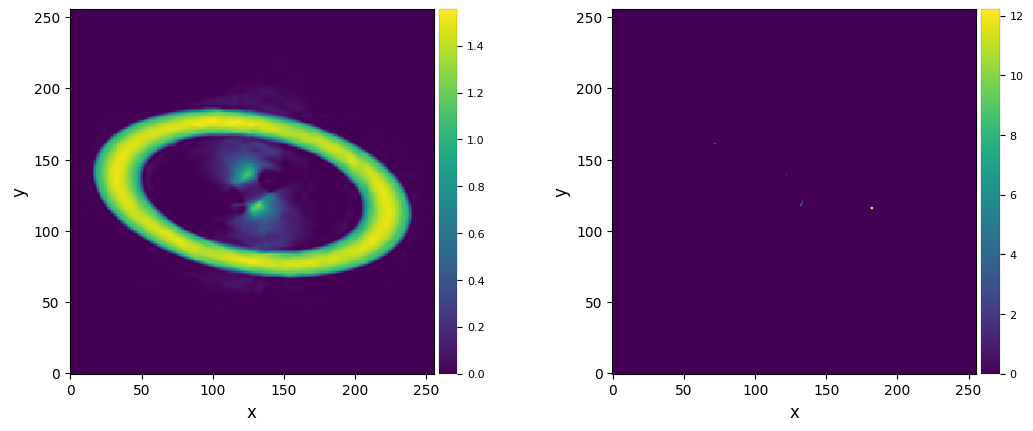

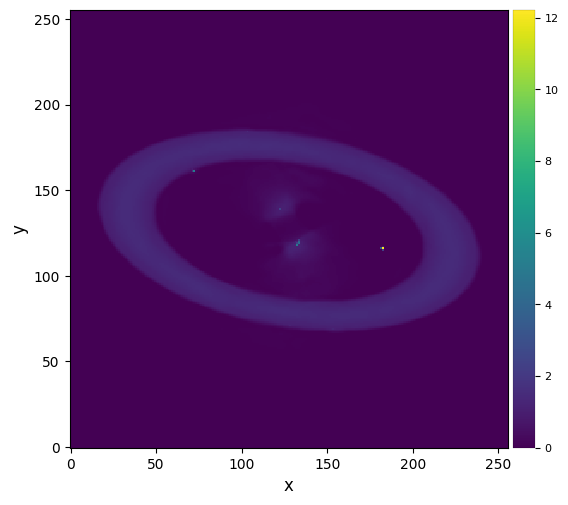

In [8]:
plots((algo.X[0],algo.X[1]))
plots((algo.X[0] + algo.X[1]))

We compute the recovered intensity for both injected companions:

In [9]:
x_planet_1,y_planet_1,intensity_planet_1= add_synthetic_signal['planets_positions_intensities'][0]
x_planet_2,y_planet_2,intensity_planet_2= add_synthetic_signal['planets_positions_intensities'][1]

rec_planet_1_intensity = np.sum(algo.X[1][x_planet_1-2:x_planet_1+2,y_planet_1-2:y_planet_1+2])
error_est_1 = np.sqrt(np.sum( (rec_planet_1_intensity - intensity_planet_1)**2/intensity_planet_1**2))
print('Recovered of first planet is {} out of a total of {}'.format(rec_planet_1_intensity,intensity_planet_1))
print('The LSE of the estimation is thus {}'.format(error_est_1))


rec_planet_2_intensity = np.sum(algo.X[1][x_planet_2-2:x_planet_2+2,y_planet_2-2:y_planet_2+2])
error_est_2 = np.sqrt(np.sum( (rec_planet_2_intensity - intensity_planet_2)**2/intensity_planet_2**2))
print('Recovered of second planet is {} out of a total of {}'.format(rec_planet_2_intensity,intensity_planet_2))
print('The LSE of the estimation is thus {}'.format(error_est_2))



Recovered of first planet is 6.0385422706604 out of a total of 10
The LSE of the estimation is thus 0.39614577293395997
Recovered of second planet is 18.98017120361328 out of a total of 20
The LSE of the estimation is thus 0.05099143981933594


Finally, instead of running 'algo.solve_optim()', we can also use the pyds9 package to display the current estimation of the disk and exoplanetary signal:

In [ ]:
import pyds9
ds9_frame = pyds9.DS9()
ds9_frame.set_np2arr(algo.X[0]+algo.X[1])

while not algo.parameters_algo['stop-optim']:
    algo.mayonnaise_pipeline_iteration()
    try:
        ds9_frame.set_np2arr(algo.X[0]+algo.X[1])
    except:
        ds9_frame = pyds9.DS9()
        ds9_frame.set_np2arr(algo.X[0]+algo.X[1])

In [10]:
vip.fits.write_fits('example-data/adi-cube.fits',algo.data)

Fits file successfully overwritten
